# Fine-Tuning Transformers

Restart the notebook at this point to continue

In [1]:
import torch
import numpy as np

# set random seed
seed = 42
torch.manual_seed(seed)

In [24]:
# ! pip install datasets transformers huggingface_hub

In [3]:
from datasets import load_dataset

emotions = load_dataset('emotion')

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=1000)

emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the metrics to train the model on

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

In [6]:
print(emotions_encoded['train'])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})


In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=logging_steps,
    weight_decay=0.01,
    learning_rate=2e-5,
    disable_tqdm=False,
    evaluation_strategy="epoch",
    log_level="error",
    push_to_hub=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [10]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
evaluation_strategy=epoch,
fp

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer,
)

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.807200,0.286477,0.918500,0.917633
2,0.234400,0.201843,0.928000,0.927929


TrainOutput(global_step=500, training_loss=0.5207848205566407, metrics={'train_runtime': 242.0724, 'train_samples_per_second': 132.192, 'train_steps_per_second': 2.065, 'total_flos': 718554424246272.0, 'train_loss': 0.5207848205566407, 'epoch': 2.0})

In [13]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [14]:
print(preds_output.metrics)

{'test_loss': 0.20184314250946045, 'test_accuracy': 0.928, 'test_f1': 0.9279288247187572, 'test_runtime': 3.7909, 'test_samples_per_second': 527.581, 'test_steps_per_second': 8.441}


In [15]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [16]:
y_preds

array([0, 0, 2, ..., 1, 1, 1])

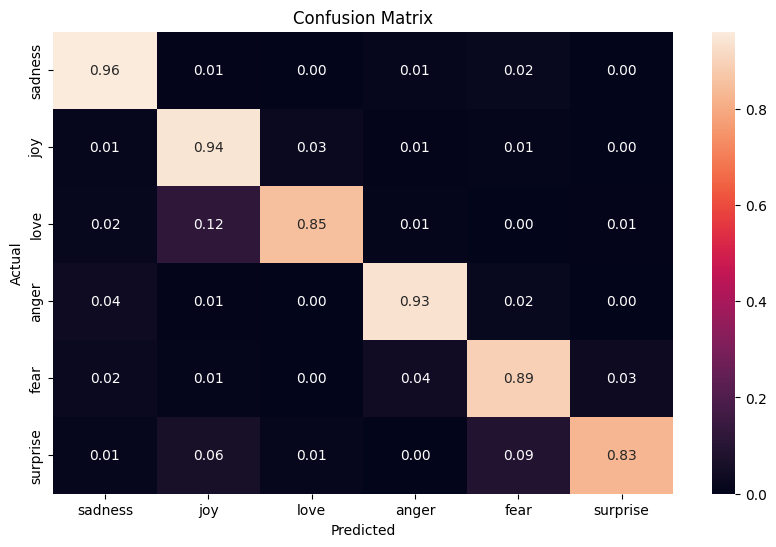

In [17]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_valid = emotions_encoded['validation']['label']
cm = confusion_matrix(y_valid, y_preds, normalize='true')

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=emotions_encoded['validation'].features['label'].names,
            yticklabels=emotions_encoded['validation'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Error analysis

In [18]:
print(tokenizer.model_input_names)

['input_ids', 'attention_mask']


In [19]:
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
      outputs = model(**inputs)
      pred_label = torch.argmax(outputs.logits, dim=1)
      loss = cross_entropy(outputs.logits, batch['label'].to(device), reduction='none')

    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

In [20]:
# convert our dataset back to pytorch
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [21]:
# compute loss values using map

emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_labels, batched=True, batch_size=100)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
emotions_encoded["validation"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [28]:
def label_int_to_str(row):
    # use the int2str method of the label feature to convert the integer label to string
    return emotions['train'].features['label'].int2str(row)

In [29]:
emotions_encoded.set_format('pandas')
#
cols = ['text', 'label', 'predicted_label', 'loss']
df = emotions_encoded['validation'][:][cols]
df['predicted_label'] = df['predicted_label'].apply(label_int_to_str)
df['label'] = df['label'].apply(label_int_to_str)

In [30]:
df.sort_values('loss', ascending=False).head()

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.472510
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.324342
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.181994
1801,i feel that he was being overshadowed by the s...,love,sadness,4.985314
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.884164


In [31]:
df.sort_values('loss', ascending=True).head()

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.014716
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.015020
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.015023
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.015138
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.015142


# Saving and sharing the model

In [33]:
trainer.push_to_hub(commit_message="Training completed")

from transformers import pipeline

model_id = "brtenorio/distilbert-base-uncased-finetuned-emotions"
classifier = pipeline("text-classification", model=model_id)

No files have been modified since last commit. Skipping to prevent empty commit.


In [34]:
#test the pipeline with a simple tweet

tweet = "I saw a movie today and it was really good!"
classifier(tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.023815274238586426},
  {'label': 'LABEL_1', 'score': 0.8853285312652588},
  {'label': 'LABEL_2', 'score': 0.010901981964707375},
  {'label': 'LABEL_3', 'score': 0.03624045103788376},
  {'label': 'LABEL_4', 'score': 0.011493965052068233},
  {'label': 'LABEL_5', 'score': 0.03221974894404411}]]

In [ ]:
# clearly the most likely emotion was classified as joy